In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.sparse.linalg import eigs
from tqdm import tqdm

## Data preprocessing

In [2]:
adata = sc.read_h5ad('data/hnd.h5ad')

In [3]:
if not isinstance(adata.X, np.ndarray):
    adata.X = adata.X.toarray()
adata

AnnData object with n_obs × n_vars = 604 × 13771
    obs: 'Sample_ID', 'Experiment', 'Day', 'Number of Alignments', 'Cell Quality Control', 'Outlier', 'Subpopulations', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'geneid', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [4]:
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Specifying Temporal Order for Time Labels

In [6]:
obs_time = 'Day'
adata.obs[obs_time].unique()
sorted_time = ['d0', 'd1', 'd5', 'd7', 'd10', 'd30']
adata.obs[obs_time] = adata.obs[obs_time].cat.reorder_categories(sorted_time)

## PCA Embedding

In [7]:
sc.tl.pca(adata)

C:\Users\51895\AppData\Roaming\Python\Python38\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


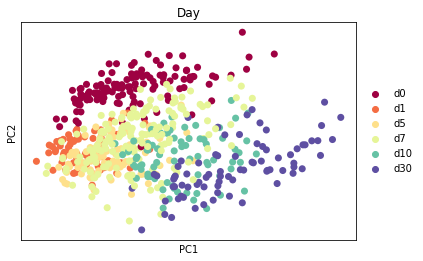

In [8]:
sc.pl.pca(adata, color=obs_time, palette=plt.cm.Spectral.name)

## UMAP Embedding

In [9]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

C:\Users\51895\AppData\Roaming\Python\Python38\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


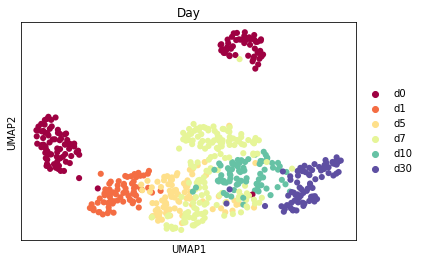

In [10]:
ax = sc.pl.umap(adata, color=obs_time, size=150, palette=plt.cm.Spectral.name)

## CytoTRACE Pseudotime

In [11]:
import scvelo as scv
from cellrank.kernels import CytoTRACEKernel

sc.pp.highly_variable_genes(adata)
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")

adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

ctk = CytoTRACEKernel(adata).compute_cytotrace()

This detected 2269 highly variable genes. 
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


C:\Users\51895\AppData\Roaming\Python\Python38\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


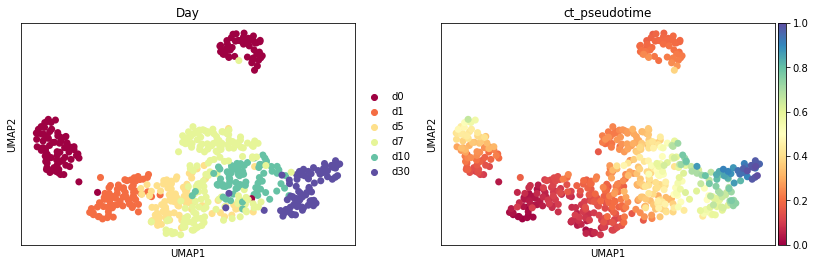

In [12]:
ax = sc.pl.umap(adata, color=[obs_time, 'ct_pseudotime'], cmap=plt.cm.Spectral.name)
plt.show()

   ## Cell Complexity Index (CCI) Pseudotime

In [13]:
def complexity_index(mcg):
    mgc = np.transpose(mcg)
    
    kc0 = np.sum(mcg, axis=1)
    kg0 = np.sum(mcg, axis=0)
    
    mcc = np.dot(mcg / np.transpose([kc0]), mgc / np.transpose([kg0]))
    
    e_val, e_vec = eigs(mcc)    
    cci = np.real(e_vec[:, 1])
    
    scc = ss.spearmanr(kc0, cci)[0]
    if scc < 0:
        cci = - cci
        
    gci = np.dot(mgc, np.transpose([cci])).flatten() / kg0
    
    cci = (cci - np.min(cci)) / (np.max(cci) - np.min(cci))
    gci = (gci - np.min(gci)) / (np.max(gci) - np.min(gci))
    
    return cci, gci

In [14]:
cci, gci = complexity_index(adata.X)

In [15]:
adata.obs['cci_pseudotime'] = 1 - cci

C:\Users\51895\AppData\Roaming\Python\Python38\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


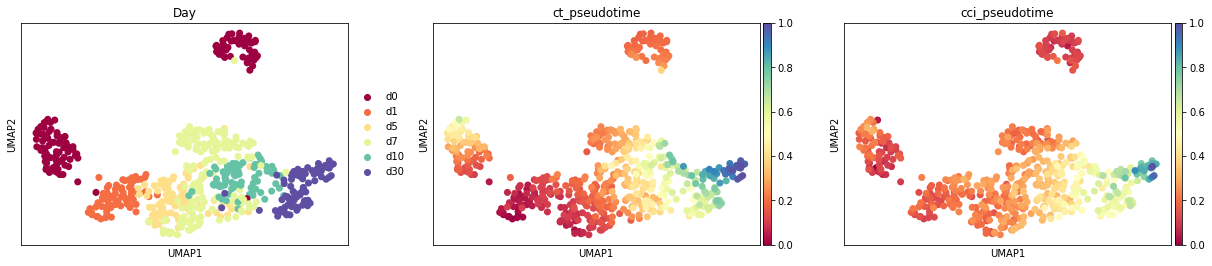

In [16]:
ax = sc.pl.umap(adata, color=[obs_time, 'ct_pseudotime', 'cci_pseudotime'], cmap=plt.cm.Spectral.name)
plt.show()

## Box Plots of Normalized Gene Diversity, CytoTRACE Pseudotime, and CCI Pseudotime

In [17]:
adata.obs['gene_diversity'] = np.sum(adata.X, axis=1)

In [18]:
min_div = np.min(adata.obs['gene_diversity'])
max_div = np.max(adata.obs['gene_diversity'])
adata.obs['norm_gene_diversity'] = (adata.obs['gene_diversity'] - min_div) / (max_div - min_div)

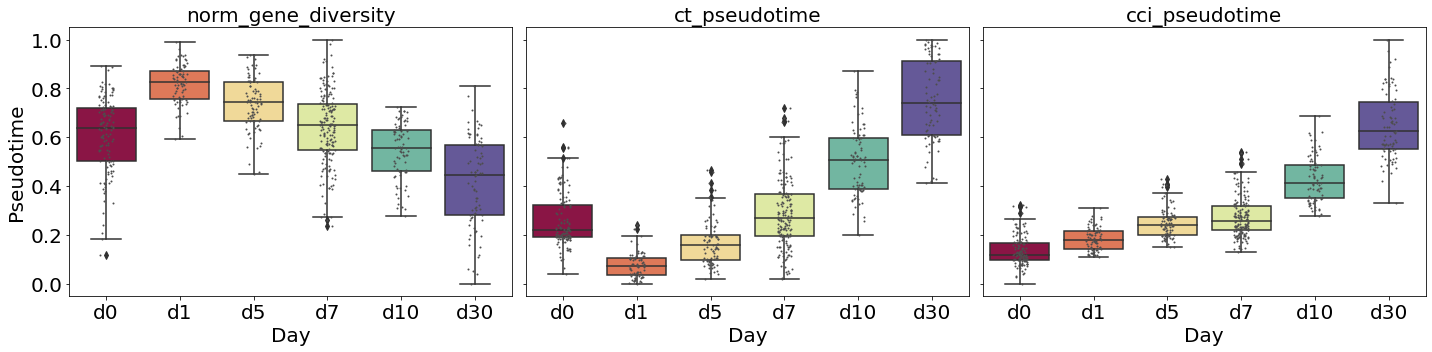

In [19]:
fontsize = 20
time_colors = dict(zip(sorted_time, adata.uns['{}_colors'.format(obs_time)]))

f, axes = plt.subplots(1, 3, figsize=(20, 5))

keys = ['norm_gene_diversity', 'ct_pseudotime', 'cci_pseudotime']

n = 0
for key in keys:
    sns.boxplot(x=obs_time, y=key, data=adata.obs, palette=time_colors, ax=axes[n])
    sns.stripplot(x=obs_time, y=key, data=adata.obs, size=2.0, color=".3", linewidth=0, ax=axes[n])
    n += 1
    
for ax in axes:
    ax.set_xlabel(obs_time, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

axes[0].set_ylabel('Pseudotime', fontsize=fontsize)
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

for n in range(len(keys)):
    axes[n].set_title(keys[n], fontsize=fontsize)

plt.tight_layout()
plt.show()

## Spearman Correlation Coeffience (SCC)

In [20]:
time_unique = adata.obs[obs_time].unique()
time_dict = dict(zip(sorted_time, range(len(time_unique))))
time_order = [time_dict[t] for t in adata.obs[obs_time]]

reverse_list = [i for i in range(len(time_unique))]
reverse_list.reverse()
reverse_time_dict = dict(zip(sorted_time, reverse_list))
reverse_time_order = [reverse_time_dict[t] for t in adata.obs[obs_time]] 

In [21]:
scc_ct = ss.spearmanr(adata.obs['ct_pseudotime'], time_order)[0]
scc_cci = ss.spearmanr(adata.obs['cci_pseudotime'], time_order)[0]
print('scc_ct: ', scc_ct)
print('scc_cci: ', scc_cci)

scc_ct:  0.6165896470366607
scc_cci:  0.8488504446965098


## Calculating Complexity at Each Order for Cells and Genes

In [22]:
def cg_complexity(mcg, nmax=30):
    mcg = mcg.astype(np.float64)
    mgc = np.transpose(mcg)
    
    kc = []
    kg = []
    
    kc.append(np.sum(mcg, axis=1))
    kg.append(np.sum(mcg, axis=0))

    for n in range(1, nmax):       
        kc.append(np.dot(mcg, np.transpose([kg[n-1]])).flatten() / kc[0])
        kg.append(np.dot(mgc, np.transpose([kc[n-1]])).flatten() / kg[0])

    kc = np.array(kc)
    kg = np.array(kg)
    
    max_kc = np.max(kc, axis=1).reshape(kc.shape[0], 1)
    min_kc = np.min(kc, axis=1).reshape(kc.shape[0], 1)
    kc = (kc - min_kc) / (max_kc - min_kc)

    max_kg = np.max(kg, axis=1).reshape(kg.shape[0], 1)
    min_kg = np.min(kg, axis=1).reshape(kg.shape[0], 1)
    kg = (kg - min_kg) / (max_kg - min_kg)
    
    return kc, kg


In [23]:
kc, kg = cg_complexity(adata.X)

## Cell complexity as a function of complexity order $N$

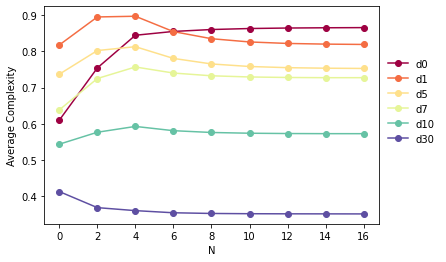

In [24]:
n_list = range(0, 18, 2)

m = 0
for t in sorted_time:
    meankc_list = []
    for n in n_list:
        meankc = np.mean(kc[n][adata.obs[obs_time]==t])
        meankc_list.append(meankc)
    plt.plot(n_list, meankc_list, marker='o', c=adata.uns['{}_colors'.format(obs_time)][m], label=t)
    m += 1
    
plt.legend(bbox_to_anchor=(1.0, 0.8), frameon=False)
plt.ylabel('Average Complexity')
plt.xlabel('N')
plt.show()

## Pseudotime Inferred by  Cell Complexity with Different Order $N$

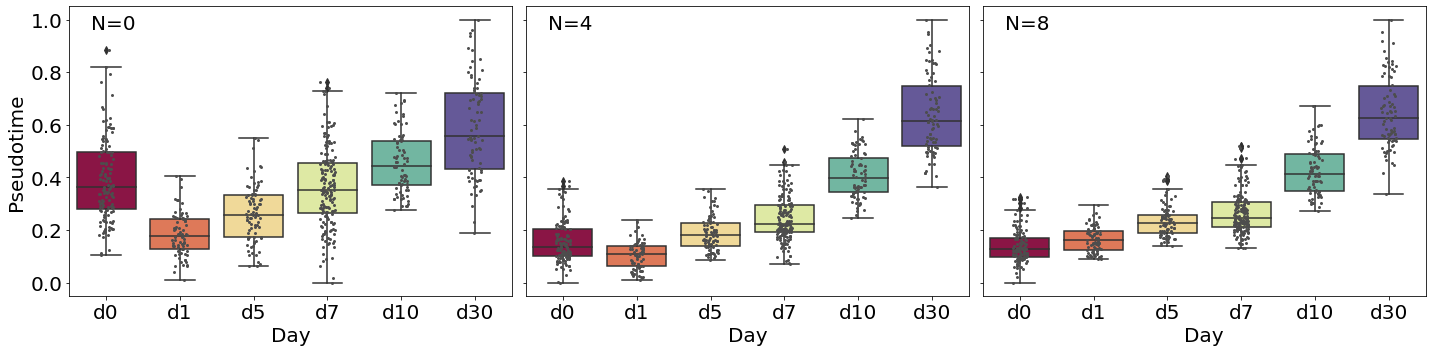

In [25]:
fontsize = 20
f, axes = plt.subplots(1, 3, figsize=(20, 5))

order_list = [0, 4, 8]
for n in range(len(order_list)):
    sns.boxplot(x=adata.obs[obs_time], y=1-kc[order_list[n]], palette=time_colors, ax=axes[n])
    sns.stripplot(x=adata.obs[obs_time], y=1-kc[order_list[n]], size=3, color=".3", linewidth=0, ax=axes[n])
    axes[n].tick_params(axis='x', rotation=0)
    axes[n].set_xlabel('')

for ax in axes:
    ax.set_xlabel(obs_time, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

axes[0].set_ylabel('Pseudotime', fontsize=fontsize)
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

for n in range(len(order_list)):
    axes[n].set_title('N={}'.format(order_list[n]), x=0.1, y=0.9, fontsize=fontsize)

plt.tight_layout()  
plt.show()

## Ranking Cells by $N$th-order complexity and CCI

In [26]:
from matplotlib.path import Path
import matplotlib.patches as patches

def convert_to_ranking(score_array):
    ranking_2d = np.empty(score_array.shape, dtype=int)
    for i in range(ranking_2d.shape[1]):
        pos = np.argsort(score_array[:, i])
        for j, pos in enumerate(pos):
            ranking_2d[pos, i] = j
        
    return ranking_2d

def ranking_plot(t, colors):
    fig, ax = plt.subplots(figsize=(10, 19))

    indent = 0.8

    for tj, color in zip(t, colors):
        s = ax.scatter(np.arange(len(tj)), tj, marker='o', color=color, s=1, zorder=3)
        verts = [(i + d, tij) for i, tij in enumerate(tj) for d in (-indent, 0, indent)][1:-1]
        codes = [Path.MOVETO] + [Path.CURVE4] * (len(verts) - 1)
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=0.5, edgecolor=color)
        ax.add_patch(patch)

    return fig, ax

In [27]:
n_choice = adata.X.shape[0]
choice = np.random.choice(kc.shape[1], n_choice, replace=False)
choice_kc = kc[:, choice]
choice_cci = cci[choice]

order_list = list(range(0, 16, 2))
score_array = choice_kc[order_list]
score_array = np.vstack([score_array, choice_cci])
score_array = np.transpose(score_array)

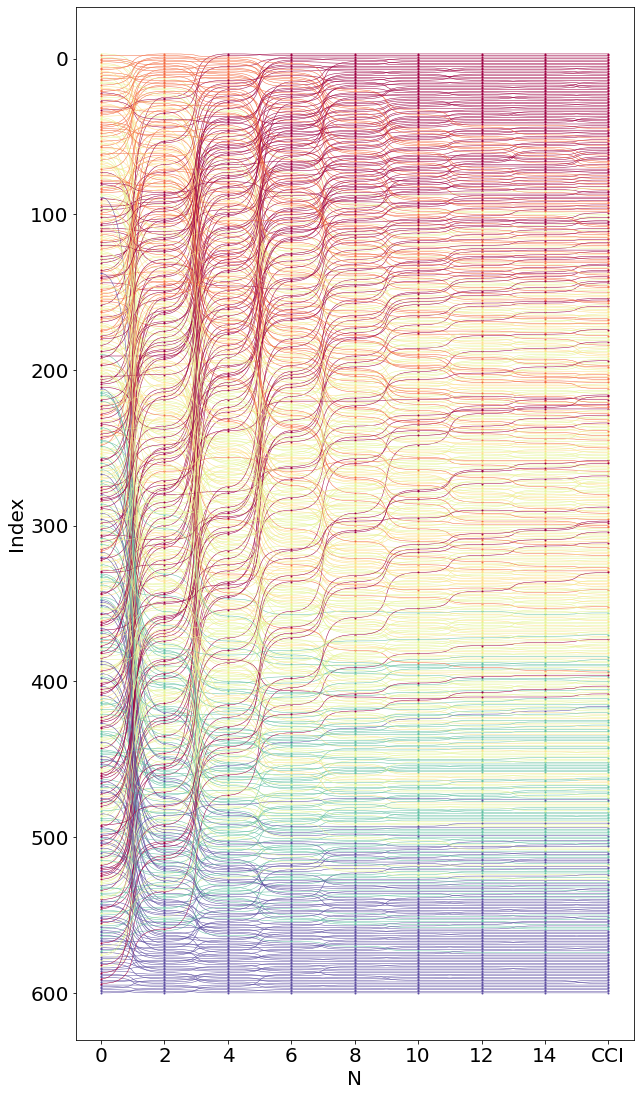

In [28]:
fontsize - 20
ranking = convert_to_ranking(score_array)
color_list = [time_colors[t] for t in adata.obs[obs_time][choice]]
fig, ax = ranking_plot(ranking, color_list)

xticks = []
xticks.extend([str(i) for i in order_list])
xticks.append('CCI')
ax.set_xticks(range(len(xticks)))
ax.set_xticklabels(xticks, fontsize=fontsize)
yticks = range(0, n_choice+1, 100)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks[::-1], fontsize=fontsize)
ax.set_xlabel('N', fontsize=fontsize)
ax.set_ylabel('Index', fontsize=fontsize)
plt.show()

In [29]:
cell_gci = adata.X * gci
cell_mean_gci = np.sum(cell_gci, axis=1) / np.sum(adata.X, axis=1)

diversity = adata.obs['gene_diversity']
diversity_gci = np.transpose(np.vstack((diversity, cell_mean_gci)))

mean_diversity = np.mean(diversity)
mean_gci = np.mean(cell_mean_gci)

adata.obsm['X_diversity_gci'] = diversity_gci

## The Diversity-Complexity Diagrams of Single-Cell Gene Expression

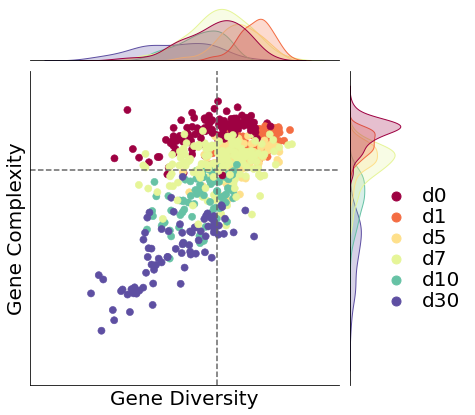

In [30]:
fontsize = 20

adata.obs['mean_gci'] = cell_mean_gci

g = sns.jointplot(x='gene_diversity',
                  y='mean_gci',
                  hue='Day',
                  s=50,
                  palette=adata.uns['Day_colors'],
                  edgecolor=None,
                  data=adata.obs)

g.ax_joint.legend_._visible=False
g.fig.legend(ncol=1, 
           bbox_to_anchor=(1.15, 0.6),
           markerscale=1.5,
           labelspacing=0.1,
           fontsize=fontsize,
           handlelength=1,
           frameon=False)

g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xticklabels([])
g.ax_joint.set_yticklabels([])
g.ax_joint.set_xlabel('Gene Diversity', fontsize=fontsize)
g.ax_joint.set_ylabel('Gene Complexity', fontsize=fontsize)
g.ax_marg_x.set_yticks([])

g.ax_joint.axvline(mean_diversity, color='#666666', linestyle='--')
g.ax_joint.axhline(mean_gci, color='#666666', linestyle='--')

plt.show()

## Silhouette Coefficient of Gene Complexity as a Function of Complexity Order $N$

In [31]:
from sklearn.metrics import silhouette_score

n_list = range(1, 13, 2)
mean_kg_list = []
for n in n_list:
    cell_kg = adata.X * kg[n]
    cell_mean_kg = np.sum(cell_kg, axis=1) / np.sum(adata.X, axis=1)
    mean_kg_list.append(cell_mean_kg)
    
mean_kg_list = np.array(mean_kg_list)

shc_kg = []
shc_kg.append(silhouette_score(np.array(adata.obs['gene_diversity']).reshape(-1, 1), reverse_time_order))
for mean_kg in mean_kg_list:
    shc_kg.append(silhouette_score(np.array(mean_kg).reshape(-1, 1), reverse_time_order))

shc_ct = silhouette_score(np.array(1-adata.obs['ct_pseudotime']).reshape(-1, 1), reverse_time_order)

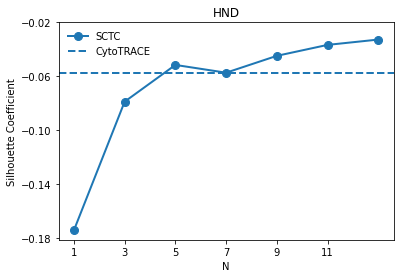

In [32]:
plt.plot(shc_kg, marker='o', markersize=8, linewidth=2, label='SCTC')
plt.axhline(shc_ct, linestyle='--', linewidth=2, label='CytoTRACE')

plt.xticks(ticks=range(len(n_list)), labels=list(n_list))
plt.yticks([-0.18, -0.14, -0.10, -0.06, -0.02])

plt.xlabel('N')
plt.ylabel('Silhouette Coefficient')

plt.legend(frameon=False)
plt.title('HND')

plt.show()

## Distributions of top genes and bottom genes

In [33]:
argsort_gci = np.argsort(gci)
argsort_gci = np.flip(argsort_gci)

In [34]:
import cmasher as cmr

new_cmap = cmr.get_sub_cmap(plt.cm.coolwarm.name, 0.25, 1.0)

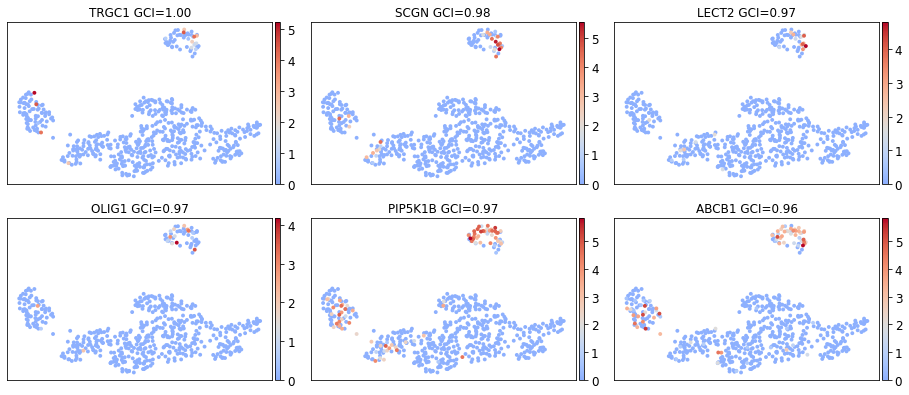

In [35]:
import matplotlib

def map_to_grid(i, nrows, ncols):
  
  x = i // ncols
  y = i % ncols

  return x, y

ntop = 6

top_gene = [adata.var.index[argsort_gci[i]] for i in range(ntop)]


nrows=2
ncols=3
figsize=4
wspace=0.1
hspace=0.1
fig,axs = plt.subplots(nrows=nrows, ncols=ncols,
                       figsize=(ncols*figsize+figsize*wspace*(ncols-1), nrows*2.8))
plt.subplots_adjust(wspace=wspace)
plt.subplots_adjust(hspace=hspace)

n = 0
for gene in top_gene:
    x, y = map_to_grid(n, nrows, ncols)
    sc.pl.umap(adata, color=gene, ax=axs[x, y], size=60, cmap=new_cmap, show=False)
    
    cbar = axs[x, y].collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.locator = matplotlib.ticker.MultipleLocator(1)
    axs[x, y].set_xlabel('')
    axs[x, y].set_ylabel('')
    axs[x, y].set_title('{} GCI={:.2f}'.format(top_gene[n], gci[argsort_gci[n]]))
    n += 1

plt.tight_layout()
plt.show()

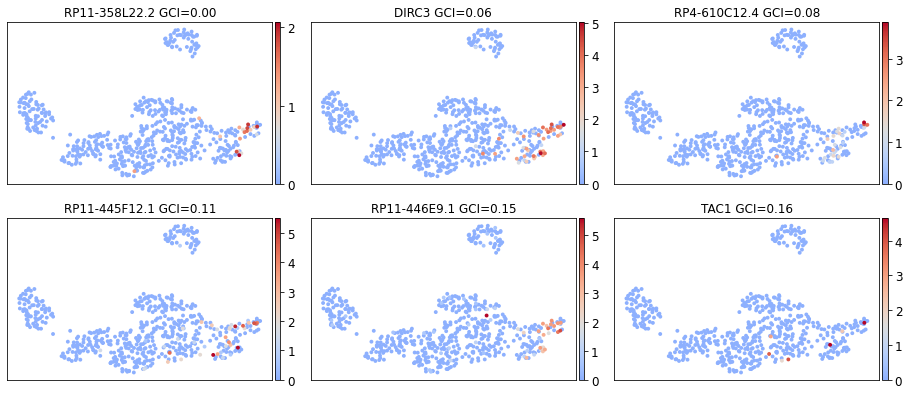

In [36]:
nbottom = 6

bottom_gene = [adata.var.index[argsort_gci[-i]] for i in range(1, nbottom+1)]

bottom_gene

nrows=2
ncols=3
figsize=4
wspace=0.1
hspace=0.1
fig,axs = plt.subplots(nrows=nrows, ncols=ncols,
                       figsize=(ncols*figsize+figsize*wspace*(ncols-1), nrows*2.8))
plt.subplots_adjust(wspace=wspace)
plt.subplots_adjust(hspace=hspace)

n = 1
for gene in bottom_gene:
    x, y = map_to_grid(n-1, nrows, ncols)
    sc.pl.umap(adata, color=gene, ax=axs[x, y], size=60, cmap=new_cmap, show=False)
    
    cbar = axs[x, y].collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.locator = matplotlib.ticker.MultipleLocator(1)
    axs[x, y].set_xlabel('')
    axs[x, y].set_ylabel('')
    axs[x, y].set_title('{} GCI={:.2f}'.format(bottom_gene[n-1], gci[argsort_gci[-n]]))
    n += 1

plt.tight_layout()
plt.show()

In [37]:
ntop = 100
top_gene = [adata.var.index[argsort_gci[i]] for i in range(ntop)]

top_gene_expr = []

for i in range(ntop):
    gene = top_gene[i]
    top_gene_expr.append([])
    for t in sorted_time:
        gene_expr = adata.X[adata.obs[obs_time]==t, adata.var.index==gene].flatten()
        top_gene_expr[i].append(np.mean(gene_expr))
        
top_gene_expr = np.array(top_gene_expr)

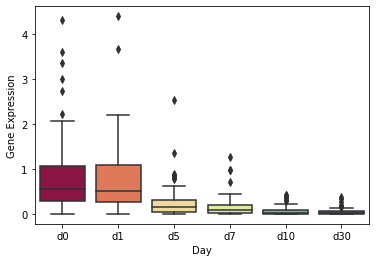

In [38]:
sns.boxplot(data=top_gene_expr, palette=[time_colors[t] for t in sorted_time])
plt.xticks(ticks=range(len(sorted_time)), labels=sorted_time)
plt.xlabel(obs_time)
plt.ylabel('Gene Expression')
plt.show()

In [39]:
nbottom = ntop
bottom_gene = [adata.var.index[argsort_gci[-i]] for i in range(1, nbottom+1)]

bottom_gene_expr = []

for i in range(nbottom):
    gene = bottom_gene[i]
    bottom_gene_expr.append([])
    for t in sorted_time:
        gene_expr = adata.X[adata.obs[obs_time]==t, adata.var.index==gene].flatten()
        bottom_gene_expr[i].append(np.mean(gene_expr))
        
bottom_gene_expr = np.array(bottom_gene_expr)

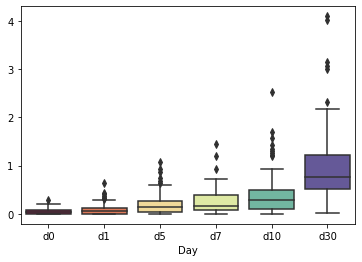

In [40]:
sns.boxplot(data=bottom_gene_expr, palette=[time_colors[t] for t in sorted_time])
plt.xticks(ticks=range(len(sorted_time)), labels=sorted_time)
plt.xlabel(obs_time)
plt.ylabel('')
plt.show()